# calculates the seasonal anomalies and the seasonal percentile categories from the gridded VCSN monthly files, using the NZ 6 regions masks and the [regionmask](https://regionmask.readthedocs.io/) library

### enter the variable name here 

In [1]:
var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean_N'
# var_name = 'SoilM'
# var_name = 'Wind'
# var_name = 'Rad'

### number of quantiles

In [2]:
num_quantiles = 3

variable name should be in:  

+ original VCSN variables:  

['MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N'] 

or: 

+ derived variables: 

    + Tmean:  (Tmin + Tmax) / 2 
    + Tmean_N: (Tmin_N + Tmax_N) / 2 )

In [3]:
import os
import sys
import pathlib

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from itertools import product

In [5]:
import salem
import geopandas as gpd

In [6]:
import xarray as xr

### path definitions 

In [7]:
HOME = pathlib.Path.home()

In [8]:
CWD = pathlib.Path.cwd() 

### path to the mask dataset (for regionmask)

In [9]:
mask_path = pathlib.Path('/media/nicolasf/END19101/data/VCSN/')

### path to the VCSN data 

In [10]:
vcsn_path = HOME.joinpath(f'operational/VCSN/data/NC/MONTHLY/{var_name.upper()}')

### output path root for the CSV files 

In [11]:
csv_path = HOME.joinpath("research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions")

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [12]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

### big_var is the simplified version of the variable, so Rain_bc --> RAIN, Tmin_N --> TMIN ...

In [13]:
big_var = var_name.split('_')[0].upper()

In [14]:
HOME = pathlib.Path.home()

### open the VCSN monthly dataset 

In [15]:
vcsn_path

PosixPath('/home/nicolasf/operational/VCSN/data/NC/MONTHLY/SOILM')

In [16]:
dset = xr.open_dataset(vcsn_path.joinpath(f'VCSN_gridded_{var_name}_1979-01_2019-12.nc')) 

In [17]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    SoilM    (time, lat, lon) float64 ...
    agent    (lat, lon) float32 ...

### calculates the seasonal average (or sum if rainfall ..)

In [18]:
if "Rain" in var_name: 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

### get rid of first 2 time-steps now missing 

In [19]:
dset = dset.isel(time=slice(2,None))

### reads the mask dataset 

In [20]:
regions_mask = xr.open_dataset(mask_path.joinpath("NZ_6_regions_mask.nc"))  

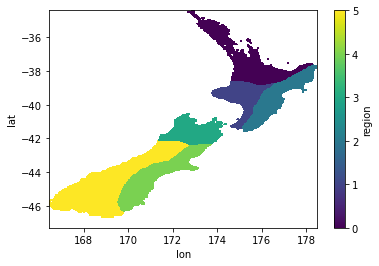

In [21]:
regions_mask['region'].plot()

### get the quantile values 

In [22]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [23]:
quant_values = quant_values[1:-1]

In [24]:
quant_values

array([0.33333333, 0.66666667])

In [25]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [26]:
col_labs

['Q33', 'Q66']

In [27]:
list_regions = ['NNI','ENI','WNI','NSI','WSI','ESI'] 

In [28]:
quantiles_dict = {}

for i, region_name in enumerate(list_regions): 

    # create a copy of the original dataset 
    region = dset.copy() 
    
    # get the mask for the region 
    region['mask'] = regions_mask[region_name] 
    
    # multiply the gridded values by the mask 
    region = region[var_name] * region['mask']
        
    # calculate the regional average 
    ts = region.mean(dim=['lat','lon'])
    
    # casts the resulting time-series into a dataframe 
    ts_df = ts.to_dataframe(name=var_name)
    ts_series = ts_df.loc[:,var_name]
    
    # now loop over each month (i.e. season) to calculate the percentiles-based categories
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        # extract the values for the month 
        ts_series_m = ts_series[ts_series.index.month == month]
        
        # subset to get the climatological period (1981 - 2010)
        clim = ts_series_m.loc['1981':'2010']
        
        # calculates the climatological quantiles 
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        # use [pd.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) to derive the categories
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    # concatenate the monthly time-series of quantile categories 
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    # sort in chronological order 
    ts_series_cat = ts_series_cat.sort_index()
    
    # add the column to the dataframe 
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    # calculates the anomalies with respect to the 1981 - 2010 climatology 
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name].groupby(ts_df.index.month).apply(demean)
    
    opath = csv_path.joinpath(f"{big_var}/{region_name}") 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    # saves the time-series to csv 
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_regionmask.csv')
    
    # calculate the descriptive statistics per quantile category, and saves to disk
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}_{big_var}_{num_quantiles}_regionmask.csv')
    
    print(f"region {region_name} processed for variable {big_var}")
    

region NNI processed for variable SOILM
region ENI processed for variable SOILM
region WNI processed for variable SOILM
region NSI processed for variable SOILM
region WSI processed for variable SOILM
region ESI processed for variable SOILM


### saves the climatological terciles calculated from the VCSN regional aggregates

In [29]:
quantiles_list = []
for region_name in ['NNI','ENI','WNI','NSI','WSI','ESI']: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [30]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [31]:
quantiles_df

NNI                   ENI                   WNI             \
              Q33        Q66        Q33        Q66        Q33        Q66   
season                                                                     
1      -60.312697 -49.690602 -72.155515 -64.504013 -46.665510 -36.526106   
2      -77.464977 -65.597955 -87.479164 -67.588988 -57.994315 -52.161638   
3      -84.187148 -66.735156 -82.956549 -75.521427 -69.749156 -57.610356   
4      -71.417412 -55.311720 -71.789067 -56.829930 -67.642738 -50.096915   
5      -49.508380 -35.481942 -50.249454 -36.134495 -44.678199 -33.911860   
6      -23.398505 -16.260560 -29.664599 -13.362806 -19.837409 -13.492884   
7       -5.713081  -2.068676  -9.883006  -3.082240  -3.862592  -0.606641   
8        1.112407   2.279594  -1.308544   1.367413   0.678033   3.808834   
9       -1.159978   0.810800  -3.782144  -1.704566  -0.365511   2.211197   
10      -7.334121  -4.628086 -14.322157  -9.687485  -3.991778  -1.125916   
11     -23.735811 -16.549874 -31.765695 -25.460929 -15.324638 -10.788977   
12     -42.490992 -34.202732 -53.775388 -44.135405 -27.680840 -21.020751   

              NSI                   WSI                    ESI             
              Q33        Q66        Q33        Q66         Q33        Q66  
season                                                                     
1      -48.487786 -35.507788 -32.368109 -19.257817  -94.722541 -78.985064  
2      -61.683172 -44.866863 -37.556532 -27.744471 -108.130853 -91.144492  
3      -64.336640 -45.645548 -38.952521 -31.032391 -108.009085 -96.374104  
4      -52.414955 -43.833381 -29.470075 -24.546294 -100.343599 -87.739786  
5      -36.328622 -25.406331 -17.156227  -9.594401  -84.229338 -70.742447  
6      -18.626542 -11.360012  -3.680465   1.410285  -59.729282 -48.895390  
7       -5.563735  -1.956425   2.329216   7.078141  -40.325670 -26.305642  
8       -0.204783   1.289210   4.191921   6.906016  -25.892664 -12.182746  
9       -1.360195   0.669747   2.947914   5.136171  -22.920738 -12.599927  
10      -5.917065  -2.357251   0.120190   2.871980  -33.092969 -23.493273  
11     -16.440601 -10.355827  -8.511272  -2.685139  -55.282991 -43.808384  
12     -30.857130 -21.313168 -20.732301 -11.554157  -76.344576 -64.154820

### saves the quantile climatology 

In [32]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{big_var}_regionmask.csv')

### Now do some comparisons between previous calculations of the tercile categories and the one using regionmask

In [33]:
for region_name in list_regions: 
    df_orig = pd.read_csv(csv_path.joinpath(f"{big_var}/{region_name}/TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_salem.csv"), index_col=0, parse_dates=True)
    df_reg_mask = pd.read_csv(csv_path.joinpath(f"{big_var}/{region_name}/TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_regionmask.csv"), index_col=0, parse_dates=True)
    
    print(f"percent matching categories, {big_var}, {region_name} = {(df_orig.loc[:,f'cat_{num_quantiles}'] == df_reg_mask.loc[:,f'cat_{num_quantiles}']).sum() / len(df_orig)}")
    
    # count the number of seasons in each category for each year, and saves the outputs
    
    df_orig_count = df_orig.groupby([df_orig.index.year, f'cat_{num_quantiles}']).size().unstack(fill_value=0)
    df_reg_mask_count = df_reg_mask.groupby([df_reg_mask.index.year, f'cat_{num_quantiles}']).size().unstack(fill_value=0)
    
    df_counts = pd.concat([df_orig_count, df_reg_mask_count], axis=1)
    
    df_counts.columns = pd.MultiIndex.from_product([['salem','regionmask'],list(range(1, num_quantiles + 1))])
    
    df_counts.to_csv(csv_path.joinpath(f"{big_var}/{region_name}/salem_region_mask_{region_name}_{big_var}_{num_quantiles}_salem_regionmask_counts.csv")) 

percent matching categories, SOILM, NNI = 0.9918367346938776
percent matching categories, SOILM, ENI = 0.9714285714285714
percent matching categories, SOILM, WNI = 0.9938775510204082
percent matching categories, SOILM, NSI = 0.9979591836734694
percent matching categories, SOILM, WSI = 0.9775510204081632
percent matching categories, SOILM, ESI = 0.9918367346938776


In [34]:
(df_counts.xs('salem', axis=1) - df_counts.xs('regionmask', axis=1))

,1,2,3
time,,,
1979,0,0,0
1980,0,0,0
1981,0,0,0
1982,-1,1,0
1983,0,0,0
1984,0,0,0
1985,0,0,0
1986,0,0,0
1987,0,0,0
